In [1]:
import numpy as np
#import pyccl as ccl
import camb
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from onepower import Spectra

from defaults_dictionary import kwargs

from matplotlib import rc

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)

plt.rcParams.update({"font.size": 16})

In [2]:
# Cosmmon parameters
# -----------------------

omega_m = 0.3       # Total matter density (cold dark matter + baryonic matter)
omega_c = 0.25      # Cold dark matter density
omega_b = 0.05      # Baryonic matter density

h0 = 0.7            # Dimensionless Hubble parameter
ns = 0.9            # Spectral index

k_lower = -4 # k-range [h/Mpc]
k_upper = 1  # k-range [h/Mpc]

# CAMB settings
# -----------------------
# Cosmology
camb_cosmo = {
    'omch2': omega_c * h0 ** 2,  # Omega_c * h^2 (CDM density)
    'ombh2': omega_b * h0 ** 2,  # Omega_b * h^2 (baryon density)
    'H0': h0 * 100,              # Hubble constant in km/s/Mpc
    'ns': ns,                    # Spectral index
    'As': 2.1e-9,                # Scalar amplitude
    'num_massive_neutrinos': 0,  # Effective number of massive neutrinos
    'mnu': 0,                     # Sum of neutrino masses in eV (set to 0)
    'TCMB': 2.7255,
    'w': -1.0,
    'wa': 0.0
}

# Redshift and k-range settings
z = np.linspace(0,3,100)
kmin = 10 ** k_lower
kmax = 10 ** k_upper
nk = 5000

# OnePower settings
# -----------------------------
# Cosmology
params_cosmo = {
    'omega_c': omega_c,    # Cold dark matter density
    'omega_m': omega_m,    # Total matter density
    'omega_b': omega_b,    # Baryonic matter density
    'h0': h0,              # Dimensionless Hubble parameter
    'n_s': ns,             # Spectral index (note different key name than CAMB)
#    'sigma_8': 0.8,        # RMS linear density fluctuation in 8 Mpc/h spheres
    'm_nu': 0.0,          # Neutrino mass
    'tcmb': 2.7255,
    'w0': -1.0,
    'wa': 0.0
}

# Power Spectrum
params_pk = {
    'k_vec': np.logspace(k_lower, k_upper, nk),
    'lnk_min': float(np.log(10**(k_lower))),
    'lnk_max': float(np.log(10**(k_upper))),
    'dlnk': float((np.log(10**(k_upper)) - np.log(10**(k_lower))) / nk),
    'z_vec': np.array([0.0]),
#    'growth_model': 'CambGrowth',
}

In [3]:
def compute_growth_factor(r, z, k, kmax):

    P_tot = r.get_matter_power_interpolator(nonlinear=False, extrap_kmax=kmax)

    # Evaluate it at the smallest k, for the 
    kmin = k.min()
    P_kmin = P_tot.P(z, kmin)

    D = np.sqrt(P_kmin / P_kmin[0]).squeeze()
    return np.atleast_1d(D)

Note: redshifts have been re-sorted (earliest first)


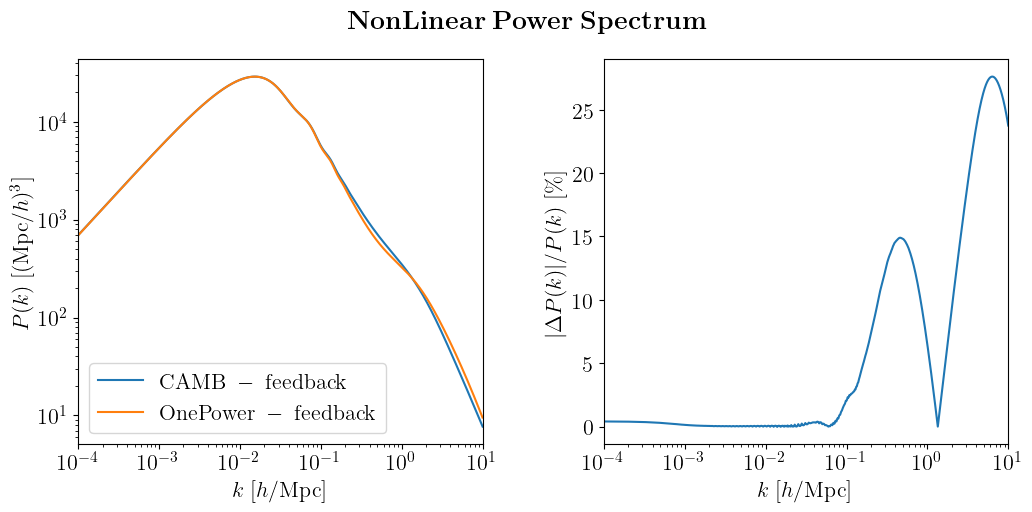

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)

# =================================================================================
# CAMB Power Spectrum
# =================================================================================

cp = camb.set_params(HMCode_logT_AGN=7.8,
    **camb_cosmo,
    halofit_version='mead2020_feedback')

cp.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_nl = powerspec

ax1.plot(kh, camb_pk_nl[0], label="$\mathrm{CAMB\ -\ feedback}$")

# =================================================================================
# Transfer Function from CAMB (for Onepower)
# =================================================================================

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z("delta_tot")
transfer_k = results.get_matter_transfer_data().transfer_z("k/h")
camb_growth = compute_growth_factor(results, z_, kh, kmax)


# =================================================================================
# Onepower Power Spectrum
# =================================================================================

model = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        growth_model='FromArray',
        growth_params={'z': z, 'd': camb_growth},
        **params_cosmo, **params_pk, **kwargs,
        mead_correction='fit')

ax1.plot(model.kh, model.power_spectrum_mm.pk_tot[0,0,:], label="$\mathrm{OnePower\ -\ feedback}$")

# =================================================================================
# Relative Difference
# =================================================================================

diff = (model.power_spectrum_mm.pk_tot[0,0,:] - camb_pk_nl[0])/camb_pk_nl[0]

ax2.plot(kh, np.abs(diff) * 100)


ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale="log",
        yscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$| \Delta P(k) | / P(k)\ [\%]$")

fig.suptitle("$\mathbf{NonLinear\ Power\ Spectrum}$")

plt.savefig("Pk_Nonlinear_compare_feedback1.pdf",
            bbox_inches="tight",
            dpi=300)

plt.show()

Note: redshifts have been re-sorted (earliest first)


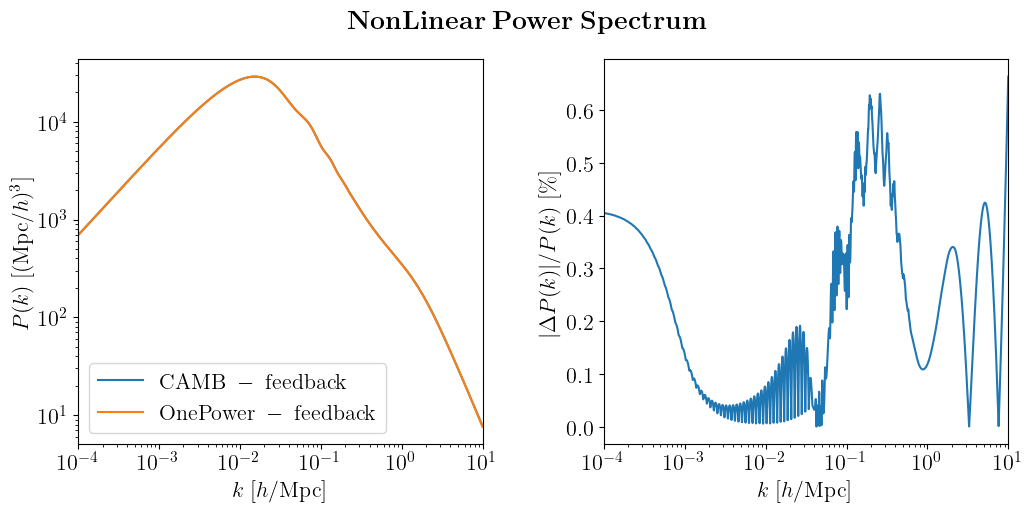

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)

# =================================================================================
# CAMB Power Spectrum
# =================================================================================

cp = camb.set_params(HMCode_logT_AGN=7.8,
    **camb_cosmo,
    halofit_version='mead2020_feedback')

cp.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_nl = powerspec

ax1.plot(kh, camb_pk_nl[0], label="$\mathrm{CAMB\ -\ feedback}$")

# =================================================================================
# Transfer Function from CAMB (for Onepower)
# =================================================================================

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z("delta_tot")
transfer_k = results.get_matter_transfer_data().transfer_z("k/h")
camb_growth = compute_growth_factor(results, z_, kh, kmax)


# =================================================================================
# Onepower Power Spectrum
# =================================================================================

model = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        growth_model='FromArray',
        growth_params={'z': z, 'd': camb_growth},
        **params_cosmo, **params_pk, **kwargs,
        mead_correction='feedback')

ax1.plot(model.kh, model.power_spectrum_mm.pk_tot[0,0,:], label="$\mathrm{OnePower\ -\ feedback}$")

# =================================================================================
# Relative Difference
# =================================================================================

diff = (model.power_spectrum_mm.pk_tot[0,0,:] - camb_pk_nl[0])/camb_pk_nl[0]

ax2.plot(kh, np.abs(diff) * 100)


ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale="log",
        yscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$| \Delta P(k) | / P(k)\ [\%]$")

fig.suptitle("$\mathbf{NonLinear\ Power\ Spectrum}$")

plt.savefig("Pk_Nonlinear_compare_feedback2.pdf",
            bbox_inches="tight",
            dpi=300)

plt.show()

Note: redshifts have been re-sorted (earliest first)


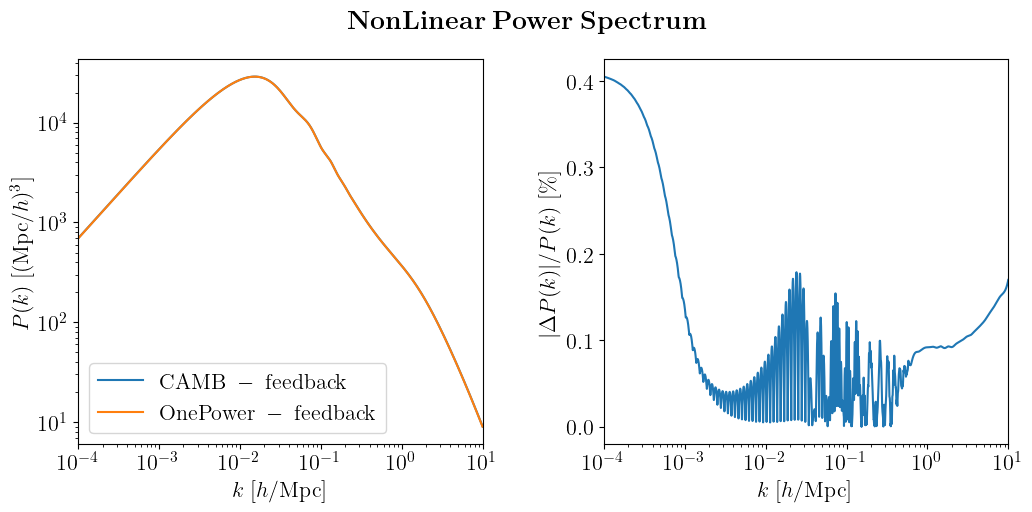

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)

# =================================================================================
# CAMB Power Spectrum
# =================================================================================

cp = camb.set_params(
    **camb_cosmo,
    halofit_version='mead2020')

cp.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_nl = powerspec

ax1.plot(kh, camb_pk_nl[0], label="$\mathrm{CAMB\ -\ feedback}$")

# =================================================================================
# Transfer Function from CAMB (for Onepower)
# =================================================================================

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z("delta_tot")
transfer_k = results.get_matter_transfer_data().transfer_z("k/h")
camb_growth = compute_growth_factor(results, z_, kh, kmax)


# =================================================================================
# Onepower Power Spectrum
# =================================================================================

model = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        growth_model='FromArray',
        growth_params={'z': z, 'd': camb_growth},
        **params_cosmo, **params_pk, **kwargs,
        mead_correction='nofeedback')

ax1.plot(model.kh, model.power_spectrum_mm.pk_tot[0,0,:], label="$\mathrm{OnePower\ -\ feedback}$")

# =================================================================================
# Relative Difference
# =================================================================================

diff = (model.power_spectrum_mm.pk_tot[0,0,:] - camb_pk_nl[0])/camb_pk_nl[0]

ax2.plot(kh, np.abs(diff) * 100)


ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale="log",
        yscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$| \Delta P(k) | / P(k)\ [\%]$")

fig.suptitle("$\mathbf{NonLinear\ Power\ Spectrum}$")

plt.savefig("Pk_Nonlinear_compare_feedback3.pdf",
            bbox_inches="tight",
            dpi=300)

plt.show()

Note: redshifts have been re-sorted (earliest first)


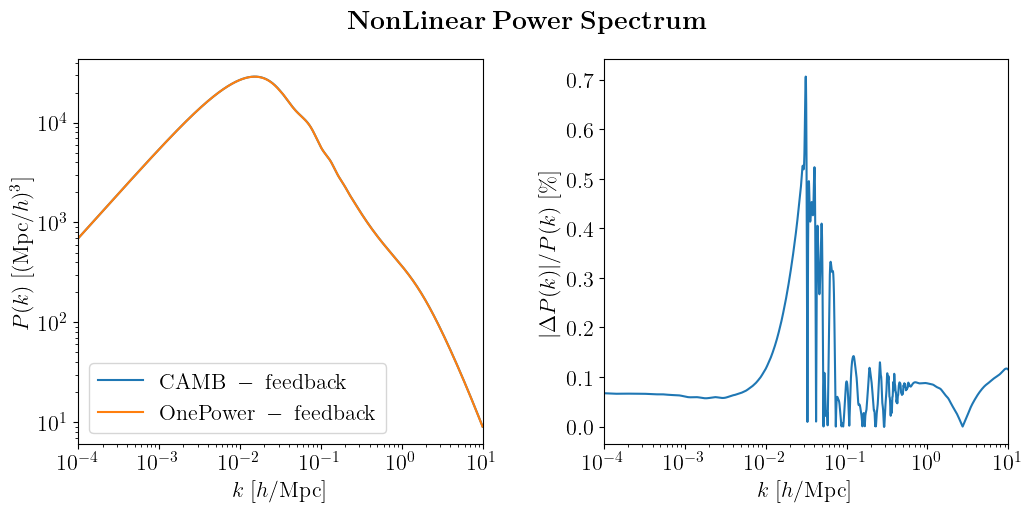

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)

# =================================================================================
# CAMB Power Spectrum
# =================================================================================

cp = camb.set_params(
    **camb_cosmo,
    halofit_version='mead2020')

cp.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_nl = powerspec

ax1.plot(kh, camb_pk_nl[0], label="$\mathrm{CAMB\ -\ feedback}$")

# =================================================================================
# Transfer Function from CAMB (for Onepower)
# =================================================================================

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z("delta_tot")
transfer_k = results.get_matter_transfer_data().transfer_z("k/h")
camb_growth = compute_growth_factor(results, z_, kh, kmax)


# =================================================================================
# Onepower Power Spectrum
# =================================================================================

model = Spectra(
        sigma_8=results.get_sigma8_0(),
        transfer_model='CAMB',
        transfer_params={},
        growth_model='CambGrowth',
        growth_params={},
        **params_cosmo, **params_pk, **kwargs,
        mead_correction='nofeedback')

ax1.plot(model.kh, model.power_spectrum_mm.pk_tot[0,0,:], label="$\mathrm{OnePower\ -\ feedback}$")

# =================================================================================
# Relative Difference
# =================================================================================

diff = (model.power_spectrum_mm.pk_tot[0,0,:] - camb_pk_nl[0])/camb_pk_nl[0]

ax2.plot(kh, np.abs(diff) * 100)


ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale="log",
        yscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$| \Delta P(k) | / P(k)\ [\%]$")

fig.suptitle("$\mathbf{NonLinear\ Power\ Spectrum}$")

plt.savefig("Pk_Nonlinear_compare_feedback4.pdf",
            bbox_inches="tight",
            dpi=300)

plt.show()